# Probability Loading Benchmark.

$$\newcommand{\braket}[2]{\left\langle{#1}\middle|{#2}\right\rangle}$$
$$\newcommand{\ket}[1]{\left|{#1}\right\rangle}$$
$$\newcommand{\bra}[1]{\left\langle{#1}\right|}$$



In [1]:
import matplotlib.pyplot as plt

## 01. Kernel

The **PL Kernel** can be defined, mathematically as follows:

Let $\mathbf{V}$ be a normalised vector of complex values:

\begin{equation}\label{eq:vector}
    \mathbf{V} = \{v_0, v_1, \cdot, v_{2^n-1} \}, v_i\in \mathbb{C} 
\end{equation}

such that

\begin{equation}\label{eq:vector_norm}
    \sum_{i=0}^{2^n-1}|v_i|^2 =1
\end{equation}

The main task of the **PL Kernel** is the creation of an operator $\mathbf{U}$, from the normalised vector $\mathbf{V}$, which satisfies equation:

\begin{equation}
    \mathbf{U}|0\rangle_n = \sum_{i=0}^{2^n-1} v_i|i\rangle_n
\end{equation}

In the case of the **TNBS** we are going to use a probability density, **pdf**, as the input vector (so $V = P$):

\begin{equation}\label{eq:probabilÇities}
    \mathbf{P} = \{p_0, p_1, \cdot, p_{2^n-1} \}, p_i\in [0,1] 
\end{equation}

where:

\begin{equation}\label{eq:prob_norm}
    \sum_{i=0}^{2^n-1}|p_i|^2 =1
\end{equation}

For this particular case:

\begin{equation}\label{eq:problem_pl2}
    \mathbf{U}_p|0\rangle_n = \sum_{i=0}^{2^n-1} \sqrt{p_i}|i\rangle_n
\end{equation}

## 02. Benchmark Test Case.


The associated **BTC** for the **PL** benchmark will be the loading of a Gausian function. The procedure will be:

1. Create the discrete probability density function
2. Creating the probability loading unitary operator $\mathbf{U}_p$
3. Execution of the quantum program and measuring of actual probability distribution.

### 1. Create the discrete probability density function.

We need to create the discrete probability density function. The **TNBS** fixes the following procedure:

* Take a random uniform distribution with a particular mean, $\tilde{\mu}$ and standard deviation, $\tilde{\sigma}$, selected within the following ranges:
    * $\tilde{\mu} \in [-2, 2]$
    * $\tilde{\sigma} \in [0.1, 2]$
* So the normal \textbf{PDF} is: $N_{\tilde{\mu},\tilde{\sigma}} (x)$ 
* Set the number of qubits to $n$.
* Create an array of $2^n$ values: $\mathbf{x}=\{x_0, x_1, x_2, \cdots, x_{2^n-1}\}$ where
    * $x_0$ such that $$\int _{-\infty} ^{x_0} N_{\tilde{\mu},\tilde{\sigma}}(x)dx = 0.05$$
    * $x_{2^n-1}$ such that $$\int _{-\infty} ^{x_{2^n-1}}N_{\tilde{\mu},\tilde{\sigma}}(x) dx = 0.95$$
    * $x_{i+1} = x_i + \Delta x$
    * $\Delta x = \frac{x_{2^n-1}-x_0}{2^n}$
* Create a $2^n$ values array, $\mathbf{P}$ from $\mathbf{x}$ by:  
    $$\mathbf{P}(\mathbf{x}) = \{ P(x_0), P(x_1), \cdots, P(x_{2^n-1}) \} = \{N_{\tilde{\mu},\tilde{\sigma}}(x_0), N_{\tilde{\mu},\tilde{\sigma}}(x_1), \cdots, N_{\tilde{\mu},\tilde{\sigma}}(x_{2^n-1}) \}$$
* Normalize the $\mathbf{P}$ array: 
    $$\mathbf{P_{norm}}(\mathbf{x}) = \{ P_{norm}(x_0), P_{norm}(x_1), \cdots, P_{norm}(x_{2^n-1}) \}$$
    where $$P_{norm}(x_{i}) = \frac{P(x_i)}{\sum_{j=0}^{2^n-1} P(x_j)}$$
* Compute the number of shots $n_{shots}$   as:
    $$n_{shots} = \min(10^6, \frac{100}{\min(\mathbf{P_{norm}}(\mathbf{x}))})$$
    
All this part of the procedure is implemented by the *get_theoric_probability* function from **PL/data\_loading** module. The function takes the number of qubits as input and returns  the following outputs:

* $x$ 
* $P_{norm}(x)$
* $\tilde{\mu}$
* $\tilde{\mu}$
* $\Delta x*$
* $n_{shots}$
* $\sum_{j=0}^{2^n-1} P(x_j)$

Each time the function is executed a different distribution will be returned with  $\tilde{\mu} \in [-2, 2]$ and $\tilde{\sigma} \in [0.1, 2]$.

In [2]:
from data_loading import get_theoric_probability

In [3]:
x, pn, mu, sigma, deltax, shots, norm = get_theoric_probability(5)
y, pny, muy, sigmay, deltay, shotsy, normy = get_theoric_probability(5)

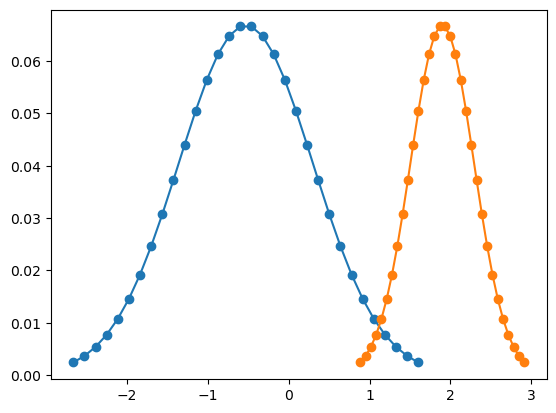

In [4]:
plt.plot(x, pn, '-o')
plt.plot(y, pny, '-o')

### 2. Creating the probability loading unitary operator $\mathbf{U}_p$,

Once the discrete probability distribution is created the unitary operator $\mathbf{U}_p$ for loading it into a quantum state should be created. This operator $\mathbf{U}_p$ acts in the following way:

\begin{equation}\label{eq:problem_pl2}
    \mathbf{U}_p|0\rangle_n = \sum_{i=0}^{2^n-1} \sqrt{p_i}|i\rangle_n
\end{equation}

The *load_probability* function from **PL/data\_loading** module creates this operator $\mathbf{U}_p$ given the discrete probability function as input array. The function needs 2 inputs:
* array with the normalised discrete probability array
* method: string for selecting the algorithm  for creating the $\mathbf{U}_p$. The algorithm for creating the $\mathbf{U}_p$ will be the one appeared in: *Grover, L., & Rudolph, T. (2002). Creating superpositions that correspond to efficiently integrable probability distributions*. In this algorithm, controlled rotations by state are needed in order to load the probability distribution into the quantum state. The selection method allows different implementations of these controlled rotations by state:
    * *brute\_force*: uses the direct implementation of controlled rotation by state.
    * *multiplexor*: the controlled rotations are implemented using **Quantum mulitplexors** as explained in: *V.V. Shende and S.S. Bullock and I.L. Markov. Synthesis of quantum-logic circuits*.
    * *KPTree*: **myqlm** implementation of the *Grover and Rudolph* algorithm  using **Quantum mulitplexors**.
    
The output of the function is a **myqlm** gate with the circuit implementation of the $\mathbf{U}_p$ operator.

In [5]:
from data_loading import load_probability

In [6]:
Up_BF = load_probability(pn, "brute_force")
Up_QMF = load_probability(pn, "multiplexor")
Up_KPtree = load_probability(pn, "KPTree")

In [7]:
%qatdisplay Up_BF --depth 2 --svg

In [8]:
%qatdisplay Up_QMF --depth 2 --svg

In [9]:
%qatdisplay Up_KPtree --depth 2 --svg

### 3. Execution of the quantum program and measuring of actual probability distribution.

